In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.transpiler import PassManager
#from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.providers.ibmq import least_busy
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.algorithms import QPE
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua import Operator
from qiskit.aqua.components.iqfts import Standard
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def matrixHamiltonian(tam, freq): #tam 4, estados 0 a 3
    h = 6.582119624 * 10**(-16)
    E = [h*freq*(i+1/2) for i in range(tam)]
    L = []
    for i in range(tam):
        L.append(list())
        for j in range(tam):
            if i==j: L[i].append(E[i])
            else: L[i].append(0)
    m = np.matrix(L)
    return m

In [3]:
def eigenvalues(m, q_bits, n_ancillae):
    result_qpe = []
    for i in range(2**q_bits):
        op = Operator(matrix=m)
        eig_res = ExactEigensolver(op, k=2**q_bits)
        eig_res = eig_res.run()
        eigv = eig_res['eigvecs']

        state = Custom(q_bits, state_vector=eigv[i])

        num_time_slices = 50
        iqft = Standard(n_ancillae)

        qpe = QPE(op, state, iqft, num_time_slices, n_ancillae, expansion_mode='suzuki',
                  expansion_order=2, shallow_circuit_concat=True)

        backend = BasicAer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=100, pass_manager=PassManager())
        result_qpe.append(qpe.run(quantum_instance))
    return result_qpe

In [9]:
m.item(3,3)

3570799.89602

In [4]:
q_bits = 2                             
m = matrixHamiltonian(2**q_bits, 1.55*10**21)
results = []
for i in range(7,12,2):
    results.append(eigenvalues(m, q_bits, i))
print(results)

[[{'translation': 3570799.89602, 'stretch': 1.4002464841485464e-07, 'top_measurement_label': '1001001', 'top_measurement_decimal': 0.5703125, 'eigvals': [502143.73537781276], 'energy': 502143.73537781276}, {'translation': 3570799.89602, 'stretch': 1.4002464841485464e-07, 'top_measurement_label': '1011011', 'top_measurement_decimal': 0.7109375, 'eigvals': [1506431.2061334373], 'energy': 1506431.2061334373}, {'translation': 3570799.89602, 'stretch': 1.4002464841485464e-07, 'top_measurement_label': '1101110', 'top_measurement_decimal': 0.859375, 'eigvals': [2566512.4252643753], 'energy': 2566512.4252643753}, {'translation': 3570799.89602, 'stretch': 1.4002464841485464e-07, 'top_measurement_label': '0000000', 'top_measurement_decimal': 0.0, 'eigvals': [-3570799.89602], 'energy': -3570799.89602}], [{'translation': 3570799.89602, 'stretch': 1.4002464841485464e-07, 'top_measurement_label': '100100101', 'top_measurement_decimal': 0.572265625, 'eigvals': [516092.17247164063], 'energy': 516092.1

In [5]:
num_ancillae = math.floor((12-7)/2)

In [6]:
energiasR = [m.item(i,i) for i in range(2**q_bits)]
energias = []
for j in range(num_ancillae+1):
    energias.append([abs(results[j][i]["energy"]) for i in range(2**q_bits)])
for j in range(num_ancillae+1):
    energias[j] = [abs(energias[j][i]-energiasR[i]) for i in range(2**q_bits)]

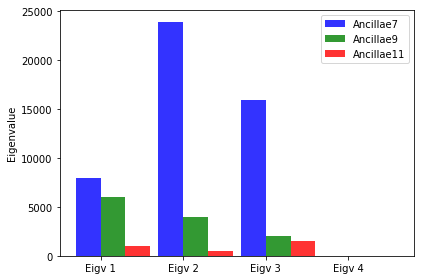

In [7]:
fig, ax = plt.subplots()

index = np.arange(2**q_bits)

bar_width = 0.3
opacity = 0.8

color = ['b', 'g', 'r', 'k']

for i in range(num_ancillae+1):
    rects= plt.bar(index + bar_width*i, energias[i], bar_width, alpha=opacity, color=color[i],label='Ancillae' + str(7+i*2))

plt.xticks(index + bar_width/2, ('Eigv 1', 'Eigv 2', 'Eigv 3', 'Eigv 4'))
plt.xlabel('')
plt.ylabel('Eigenvalue')
plt.legend()


plt.tight_layout()
plt.show()